## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [4]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [5]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [6]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [7]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [8]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [9]:
target = 'survived'

In [10]:
vars_num = [var for var in data.columns if data[var].dtypes != 'O']

vars_cat = [var for var in data.columns if data[var].dtypes == 'O']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 4


### Find missing values in variables

In [11]:
# first in numerical variables

# make a list of numerical variables with missing values
num_vars_with_na = []
for var in data.columns:
    if data[var].isnull().sum() >0 and data[var].dtypes != 'O':
        num_vars_with_na.append(var)
        
num_vars_with_na

['age', 'fare']

In [12]:
# now in categorical variables

# make a list of varibales with missing values
cat_vars_with_na = []
for var in data.columns:
    if data[var].isnull().sum() > 0 and data[var].dtypes == 'O':
        cat_vars_with_na.append(var)
# display categorical varibales with missing values
cat_vars_with_na

['cabin', 'embarked']

### Determine cardinality of categorical variables

In [13]:
# cat_vars = [var for var in data.columns if data[var].dtypes == 'O']
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

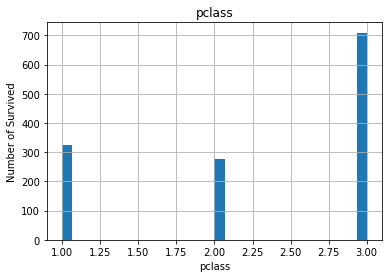

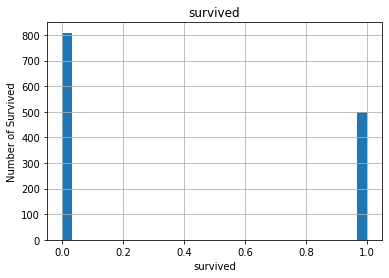

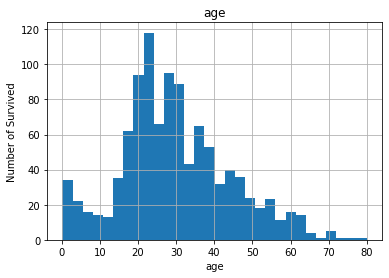

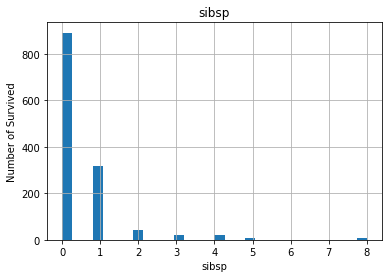

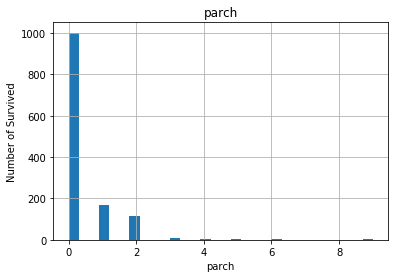

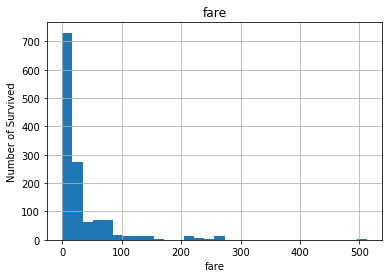

In [14]:
# Let's go ahead and analyse the distributions of numerical variables

def analyse_transformed_continuous(df, var):
    df = df.copy()
    
    df[var].hist(bins=30)
    plt.ylabel('Number of Survived')
    plt.xlabel(var)
    plt.title(var)
    plt.show()


for var in vars_num:
    analyse_transformed_continuous(data, var)

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [16]:
# X_train['cabin'].iloc[1][0:1]

In [17]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_letter_cabin(row):
    try:
        return row[0:1]
    except:
        return np.nan
    
X_train['cabin'] = X_train['cabin'].apply(get_letter_cabin)
X_test['cabin'] = X_test['cabin'].apply(get_letter_cabin)

X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
1118,3,male,25.0,0,0,7.9250,NaN,S,Mr
44,1,female,41.0,0,0,134.5000,E,C,Miss
1072,3,male,NaN,0,0,7.7333,NaN,Q,Mr
1130,3,female,18.0,0,0,7.7750,NaN,S,Miss
574,2,male,29.0,1,0,21.0000,NaN,S,Mr


### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [18]:
# dealing with missing values

for var in num_vars_with_na:
    
#     get median value on train_set
    median_val = X_train[var].median()
#     add binary missing value indicator on both train and test
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)
    
#     replace missing values by the median
    X_train[var] = X_train[var].fillna(median_val)
    X_test[var] = X_test[var].fillna(median_val)
    
# confirm that no more missing values
X_train[num_vars_with_na].isnull().sum()

age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [19]:
# Dealing with missing value

X_train[cat_vars_with_na] = X_train[cat_vars_with_na].fillna('Missing')
X_test[cat_vars_with_na] = X_test[cat_vars_with_na].fillna('Missing')

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [20]:
# make a list of categorical variables
cat_vars = []
for var in data.columns:
    if data[var].dtypes == 'O':
        cat_vars.append(var)
        
data[cat_vars].head(3)

,sex,cabin,embarked,title
0,female,B5,S,Miss
1,male,C22,S,Master
2,female,C22,S,Miss


In [21]:
def identify_frequent_labels(df, var, rare_perc):
    df = df.copy()
    
    tmp = df.groupby(var)['survived'].count() / len(df)
    return tmp[tmp > rare_perc].index

for var in cat_vars:
#     identify frequent categories
    frequent_ls = identify_frequent_labels(data, var, 0.05)
    
#     replace rare categories with the string 'Rare'
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], 'Rare')    

In [22]:
X_train.shape, X_test.shape

((1047, 11), (262, 11))

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [23]:
X_train['train'] = 1
X_test['train'] = 0

combined = pd.concat([X_train, X_test])
combined.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na,train
1118,3,male,25.0,0,0,7.9250,Rare,S,Mr,0,0,1
44,1,female,41.0,0,0,134.5000,Rare,C,Miss,0,0,1
1072,3,male,28.0,0,0,7.7333,Rare,Q,Mr,1,0,1
1130,3,female,18.0,0,0,7.7750,Rare,S,Miss,0,0,1
574,2,male,29.0,1,0,21.0000,Rare,S,Mr,0,0,1


In [24]:
encoded_df = pd.get_dummies(combined, prefix=['sex', 'cabin', 'embarked', 'title'], drop_first=True)
print(encoded_df.shape)
encoded_df.head()

(1309, 15)


,pclass,age,sibsp,parch,fare,age_na,fare_na,train,sex_male,embarked_Q,embarked_Rare,embarked_S,title_Mr,title_Mrs,title_Rare
1118,3,25.0,0,0,7.9250,0,0,1,1,0,0,1,1,0,0
44,1,41.0,0,0,134.5000,0,0,1,0,0,0,0,0,0,0
1072,3,28.0,0,0,7.7333,1,0,1,1,1,0,0,1,0,0
1130,3,18.0,0,0,7.7750,0,0,1,0,0,0,1,0,0,0
574,2,29.0,1,0,21.0000,0,0,1,1,0,0,1,1,0,0


In [25]:
X_train = encoded_df[encoded_df['train'] == 1]
X_test = encoded_df[encoded_df['train'] == 0]

X_train.drop('train', axis=1, inplace=True)
X_test.drop('train', axis=1, inplace=True)

print(X_train.shape, X_test.shape)

X_train.head()

(1047, 14) (262, 14)


C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_male,embarked_Q,embarked_Rare,embarked_S,title_Mr,title_Mrs,title_Rare
1118,3,25.0,0,0,7.9250,0,0,1,0,0,1,1,0,0
44,1,41.0,0,0,134.5000,0,0,0,0,0,0,0,0,0
1072,3,28.0,0,0,7.7333,1,0,1,1,0,0,1,0,0
1130,3,18.0,0,0,7.7750,0,0,0,0,0,1,0,0,0
574,2,29.0,1,0,21.0000,0,0,1,0,0,1,1,0,0


### Scale the variables

- Use the standard scaler from Scikit-learn

In [26]:
# set up scaler
scaler = StandardScaler()

# train scaler
scaler.fit(X_train)

# transform the train and test set
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [27]:
log_reg = LogisticRegression(C=0.0005, random_state=0)

# train the model
log_reg.fit(X_train,y_train)

# we persist the model for future use
joblib.dump(log_reg, 'logistic_regression.pkl')

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


['logistic_regression.pkl']

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [28]:
# make predictions for train set
pred = log_reg.predict(X_train)

print('train accuracy_score: {}'.format(accuracy_score(y_train, pred)))
print('train precision_score: {}'.format(roc_auc_score(y_train, log_reg.predict_proba(X_train)[:,1])))

train accuracy_score: 0.7822349570200573
train precision_score: 0.8380699381761978


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**